# 1. Data preparation

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import json

In [38]:
%load_ext autoreload
%autoreload 2
from final_project.smlm_3d.config.datasets import dataset_configs

from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import TrainingDataSet, ExperimentalDataSet, GenericDataSet
from final_project.smlm_3d.workflow_v2 import concat_dataset_features

import numpy as np


BOUND = 16
GenericDataSet.bound = BOUND

z_range = 1000

dataset = 'simulated_ideal_psf'
cfg = dataset_configs[dataset]['training']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
train_dataset = TrainingDataSet(cfg, fit_plane_z=True, transform_data=False, z_range=1000, split_data=True, add_noise=False, filter_emitters_proximity=True)
print(train_dataset.data['train'][0][0].shape)

for d in ['train', 'val', 'test']:
    _max = 1000
    _min = -1000
    train_dataset.data[d][1] = (((train_dataset.data[d][1] - _min) / (_max - _min)) * 2) - 1
    print(train_dataset.data[d][1].min(), train_dataset.data[d][1].max())
    
    
#     train_dataset.data[d][0][0] = (train_dataset.data[d][0][0] * 2) - 1
#     train_dataset.data[d][0][1] = (train_dataset.data[d][0][1] * 2) - 1
    
    
    idx = np.arange(0, train_dataset.data[d][0][0].shape[0])
    np.random.shuffle(idx)
    train_dataset.data[d][0][0] = train_dataset.data[d][0][0][idx]
    train_dataset.data[d][0][1] = train_dataset.data[d][0][1][idx]

    train_dataset.data[d][1] = train_dataset.data[d][1][idx]

# train_dataset.prepare_debug()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/simulated_ideal_psf/training/bead_stack.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/simulated_ideal_psf/training/bead_stack.csv
using image sharpness
136 emitters before filtering
64 emitters after proximity filtering.
52 emitters after borders
(7276, 32, 32, 1)
-0.9998214907766338 0.999861416981632
-0.9998379009103737 0.9999635511074767
-0.9991991627031643 0.9998102756717755


Functions above do the following operations
1. Starting from a set of X/Y images of a sample, taken at different focal depths

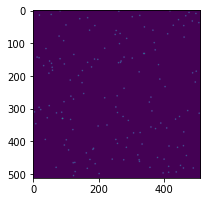

In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(train_dataset.img[100])

2. For each dot of light, cut out a stack of images around the dot (below example shows focus/defocus in steps of 200nm along Z axis)

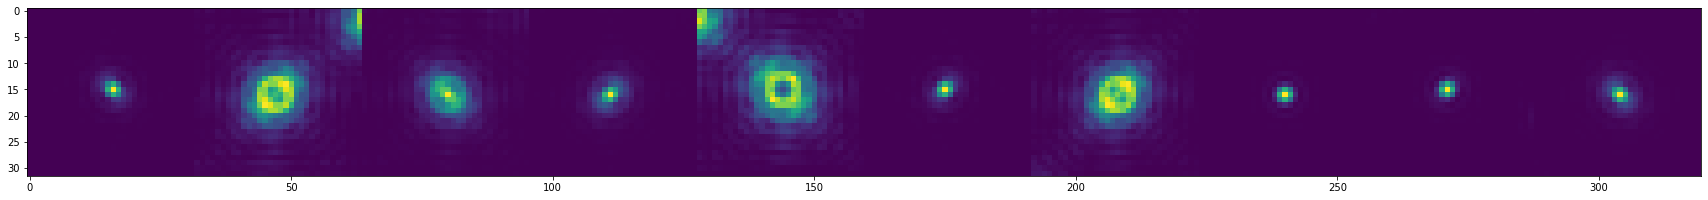

In [14]:
example_idx = 5
example_stack = np.hstack(train_dataset.data['train'][0][0][slice(example_idx*199, (example_idx+1)*199, 20)]).squeeze()
plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(example_stack)


3. Estimate 'ground truth' 0 position (focus point) of each bead using peak brightness. This is inaccurate due to high SNR ratio in image, so refine these positions by assuming dots of light sit on a plane, model new Z positions as least squares of plane and exclude poorly located points
4. Normalise each image to range [0,1]

In [15]:
example_idx = 5
example_stack = train_dataset.data['train'][0][0][slice(example_idx*199, (example_idx+1)*199, 20)].squeeze()
# Checking min/max values from for a set of images
print(example_stack.min(axis=(1,2)))
print(example_stack.max(axis=(1,2)))
      

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Rows 3 Cols 10 n_spaces 30 n_psfs 21


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


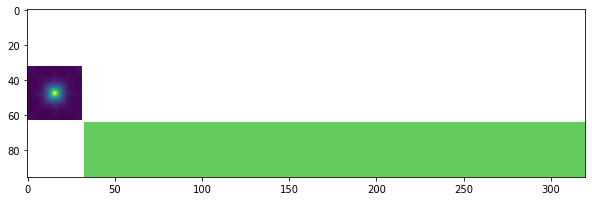

In [16]:
# Create PSF in n steps
from final_project.smlm_3d.data.visualise import grid_psfs
plt.rcParams['figure.figsize'] = [10, 10]
psf = []
for i in range(-1000, 1001, 100):
    min_z = i-25
    max_z = i+25
    idx = np.argwhere((train_dataset.data['train'][1] < max_z) & (train_dataset.data['train'][1] > min_z)).squeeze()
    imgs = train_dataset.data['train'][0][0].squeeze()[idx]
    mean_img = np.mean(imgs, axis=0)
    psf.append(mean_img)
plt.imshow(grid_psfs(psf))
plt.show()
    


(7276, 32, 32, 1)
Rows 10 Cols 10 n_spaces 100 n_psfs 100


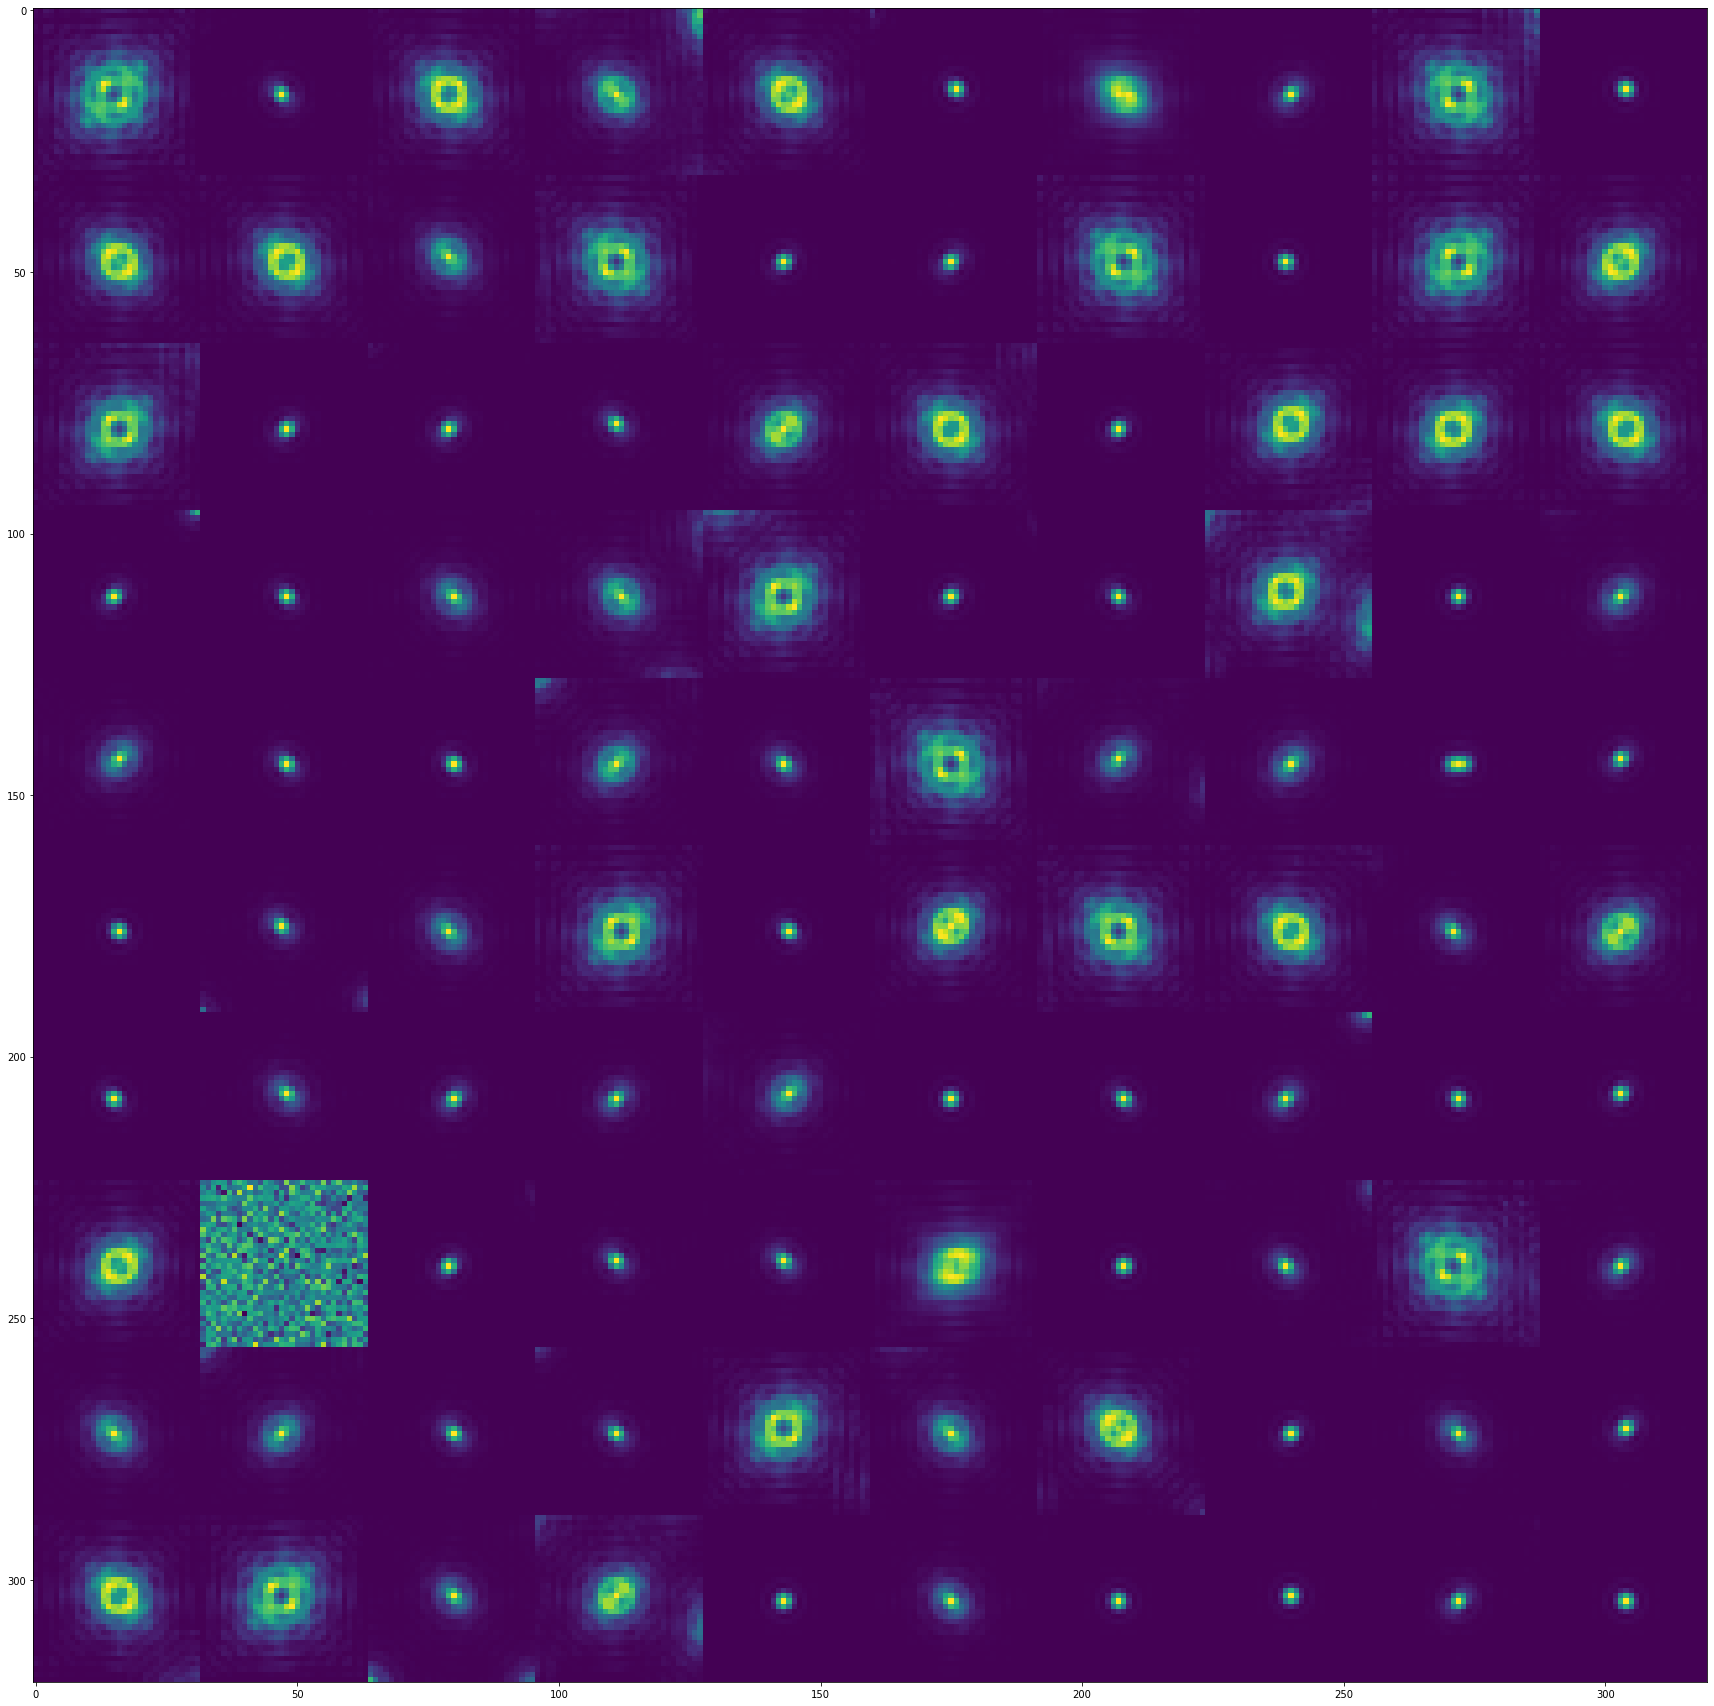

In [17]:
# checking zero-alignment of beads
from final_project.smlm_3d.data.visualise import grid_psfs
near_zero_idx = np.argwhere(abs(train_dataset.data['train'][1]) < cfg['voxel_sizes'][0]).squeeze()
near_zero_imgs = train_dataset.data['train'][0][0].squeeze()[near_zero_idx]

near_zero_imgs = near_zero_imgs[0:100]
print(train_dataset.data['train'][0][0].shape)

plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(grid_psfs(near_zero_imgs))


# 2. Training the model


In [18]:
import os

def load_deterministic_model(model):
    model_path = os.path.join('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt', dataset)
    model.load_weights(model_path).expect_partial()
    print('Loaded ', model_path)
    return model

# def save_model(model):
#     model_path = os.path.join('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt', dataset + '_bayes')
#     model.save_weights(model_path)
# #     model.save(model_path, save_format='h5')
#     print(model_path)
#     print('Saved model!')

def load_model(model):
    model_path = os.path.join('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt', dataset + '_bayes')
    print('Loading model...')
    print(model_path)
    model.load_weights(model_path)
    return model
#     return keras.models.load_model(model_path)

training (7276, 32, 32, 1) (7276, 2)
training (2080, 32, 32, 1) (2080, 2)
training (1040, 32, 32, 1) (1040, 2)


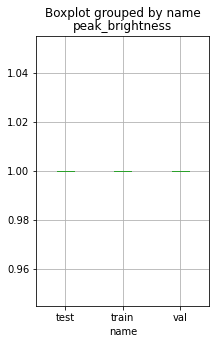

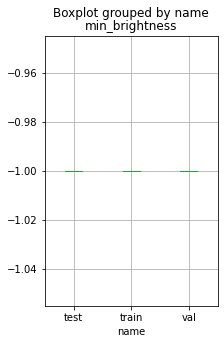

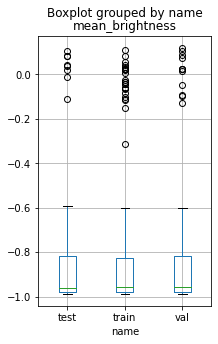

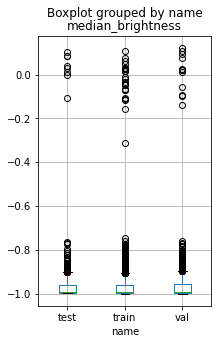

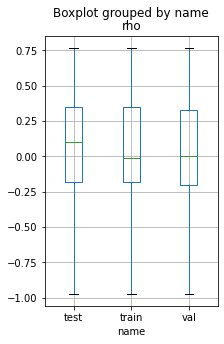

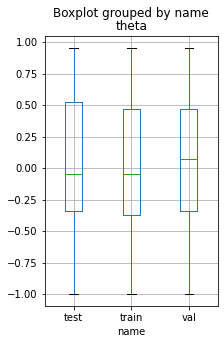

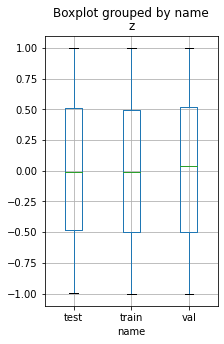

In [19]:
import pandas as pd
plt.rcParams['figure.figsize'] = [3, 5]
def gather_stats(dataset, name, dataset_type='training'):
    records = [] 
    
    if dataset_type == 'training':
        (imgs, coords), z = dataset
    else:
        imgs, coords = dataset
        z = None
    print(dataset_type, imgs.shape, coords.shape)
    
    for i, (img, coord) in enumerate(zip(imgs, coords)):
        results = {
            'name': name,
            'peak_brightness': img.max(),
            'min_brightness': img.min(),
            'mean_brightness': img.mean(),
            'median_brightness': np.median(img),
            'rho': coord[0],
            'theta': coord[1],
        }
        if z is not None:
            results['z'] = z[i]
        else:
            results['z'] = 0
        records.append(results)
        
    return pd.DataFrame.from_records(records)

if 'all' not in train_dataset.data:
    train = train_dataset.data['train']
    val = train_dataset.data['val']
    test = train_dataset.data['test']
    records = []
    records.append(gather_stats(train, 'train'))
    records.append(gather_stats(val, 'val'))
    records.append(gather_stats(test, 'test'))

    
    df = pd.concat(records)
    for col in list(df):
        if col != 'name':
            df.boxplot(by='name', column=col)
    
    

In [20]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import RandomTranslation, GaussianNoise, Normalization, BatchNormalization, ReLU
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D

from final_project.smlm_3d.workflow_v2 import eval_model

SEED = 42
class ResBlock(Model):
    def __init__(self, channels, stride=1, name='ResBlock'):
        super(ResBlock, self).__init__(name=name)
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.transpose = RandomTranslation(0.1, 0.1)
        self.feature_extraction = Sequential([
            Conv2D(64, 7, 2, padding='same'),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D(3, 2),
            ResBlock(64, name='ResBlock64_1'),
            ResBlock(64, name='ResBlock64_2'),
            ResBlock(64, name='ResBlock64_3'),
            ResBlock(128, 2, name='ResBlock128_1'),
            ResBlock(128, name='ResBlock128_2'),
            ResBlock(128, name='ResBlock128_3'),
            ResBlock(128, name='ResBlock128_4'),
            ResBlock(256, 2, name='ResBlock256_1'),
            ResBlock(256, name='ResBlock256_2'),
            ResBlock(256, name='ResBlock256_3'),
            ResBlock(256, name='ResBlock256_4'),
            ResBlock(256, name='ResBlock256_5'),
            ResBlock(256, name='ResBlock256_6'),
            ResBlock(512, 2, name='ResBlock512_1'),
            ResBlock(512, name='ResBlock512_2'),
            ResBlock(512, name='ResBlock512_3')
        ])
#         self.conv1 = Conv2D(64, 7, 2, padding='same')
#         self.bn = BatchNormalization()
#         self.relu = ReLU()
#         self.mp1 = MaxPooling2D(3, 2)

#         self.conv2_1 = ResBlock(64)
#         self.conv2_2 = ResBlock(64)
#         self.conv2_3 = ResBlock(64)

#         self.conv3_1 = ResBlock(128, 2)
#         self.conv3_2 = ResBlock(128)
#         self.conv3_3 = ResBlock(128)
#         self.conv3_4 = ResBlock(128)

#         self.conv4_1 = ResBlock(256, 2)
#         self.conv4_2 = ResBlock(256)
#         self.conv4_3 = ResBlock(256)
#         self.conv4_4 = ResBlock(256)
#         self.conv4_5 = ResBlock(256)
#         self.conv4_6 = ResBlock(256)

#         self.conv5_1 = ResBlock(512, 2)
#         self.conv5_2 = ResBlock(512)
#         self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512)
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512)
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(1)

    def call(self, inp, training):
        x, coords = inp
        
        x = self.transpose(x)
        x = self.feature_extraction(x)
#         x = self.conv1(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.mp1(x)

#         x = self.conv2_1(x)
#         x = self.conv2_2(x)
#         x = self.conv2_3(x)

#         x = self.conv3_1(x)
#         x = self.conv3_2(x)
#         x = self.conv3_3(x)
#         x = self.conv3_4(x)

#         x = self.conv4_1(x)
#         x = self.conv4_2(x)
#         x = self.conv4_3(x)
#         x = self.conv4_4(x)
#         x = self.conv4_5(x)
#         x = self.conv4_6(x)

#         x = self.conv5_1(x)
#         x = self.conv5_2(x)
#         x = self.conv5_3(x)

        x = self.pool(x)

        # Concat norm X/Y coordinates
        x = tf.concat((x, coords), axis=1)

        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        # Restrict to valid output range [-1000, 1000]    
#         x = tf.tanh(x) * 1000
        return x

#     def test_step(self, data):
#         (img, coords), y = data
#         y_pred = self((img, coords), training=False)

#         shifted_pred = shift_correction(y, y_pred)

#         self.compiled_loss(y, shifted_pred, regularization_losses=self.losses)
#         self.compiled_metrics.update_state(y, shifted_pred)
#         # Return a dict mapping metric names to current value.
#         # Note that it will include the loss (tracked in self.metrics).
#         return {m.name: m.result() for m in self.metrics}
        
            
            
def load_regression_model():

    # model = Sequential()
    # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='linear'))

    model = ResNet34()
    
#     model = res34()
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=0.001, decay=1e-6),metrics=['mean_absolute_error'])
    return model


In [37]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
tfpl = tfp.layers
tfd = tfp.distributions

from keras.layers import RandomTranslation, GaussianNoise, Normalization, BatchNormalization, ReLU
from keras import Model, Sequential
from keras import layers as Layers
from keras.layers import Dense, Dropout
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D

from final_project.smlm_3d.workflow_v2 import eval_model

SEED = 42

N = train_dataset.data['train'][1].shape[0]

from tensorflow.keras import backend as K

# def scaled_sigmoid(x):
#     return ((K.tanh(x)) * 1000)

def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution



def get_prior(kernel_size, bias_size, dtype=None):
    """
    This function should create the prior distribution, consisting of the 
    "spike and slab" distribution that is described above. 
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the prior distribution.
    """
    n = kernel_size+bias_size  
    prior_model = Sequential([tfpl.DistributionLambda(lambda t : spike_and_slab(n, dtype))])
    return prior_model

def get_posterior(kernel_size, bias_size, dtype=None):
    """
    This function should create the posterior distribution as specified above.
    The distribution should be created using the kernel_size, bias_size and dtype
    function arguments above.
    The function should then return a callable, that returns the posterior distribution.
    """
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / N

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def get_dense_variational_layer(units, prior_fn, posterior_fn, kl_weight, activation='sigmoid'):
    """
    This function should create an instance of a DenseVariational layer according 
    to the above specification. 
    The function takes the prior_fn, posterior_fn and kl_weight as arguments, which should 
    be used to define the layer.
    Your function should then return the layer instance.
    """
    return tfpl.DenseVariational(
        units=units, 
        make_posterior_fn=posterior_fn, 
        make_prior_fn=prior_fn, 
        kl_weight=kl_weight,
        activation=activation,
    )


class ResBlock_bayes(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1

# class ResNet34_bayes(Model):
#     def __init__(self, enable_dropout=False):
#         super(ResNet34_bayes, self).__init__(name='ResNet34_bayes')
#         self.transpose = RandomTranslation(0.1, 0.1)
#         self.conv1 = Conv2D(64, 7, 2, padding='same')
#         self.bn = BatchNormalization()
#         self.relu = ReLU()
#         self.mp1 = MaxPooling2D(3, 2)

#         self.conv2_1 = ResBlock_bayes(64)
#         self.conv2_2 = ResBlock_bayes(64)
#         self.conv2_3 = ResBlock_bayes(64)

#         self.conv3_1 = ResBlock_bayes(128, 2)
#         self.conv3_2 = ResBlock_bayes(128)
#         self.conv3_3 = ResBlock_bayes(128)
#         self.conv3_4 = ResBlock_bayes(128)

#         self.conv4_1 = ResBlock_bayes(256, 2)
#         self.conv4_2 = ResBlock_bayes(256)
#         self.conv4_3 = ResBlock_bayes(256)
#         self.conv4_4 = ResBlock_bayes(256)
#         self.conv4_5 = ResBlock_bayes(256)
#         self.conv4_6 = ResBlock_bayes(256)

#         self.conv5_1 = ResBlock_bayes(512, 2)
#         self.conv5_2 = ResBlock_bayes(512)
#         self.conv5_3 = ResBlock_bayes(512)

#         self.pool = GlobalAveragePooling2D()
#         self.bn2 = BatchNormalization()
#         self.fc1 = get_dense_variational_layer(512, get_prior, get_posterior, kl_weight=1/N)
#         self.fc2 = get_dense_variational_layer(512, get_prior, get_posterior, kl_weight=1/N)

#         self.fc1 = Dense(512)
#         self.fc2 = Dense(512)
#         distribution_params = Dense(units=2)
#         outputs = tfp.layers.IndependentNormal(1, convert_to_tensor_fn=tfp.distributions.Distribution.mean)

#         self.fc3 = Sequential([
#             distribution_params,
#             outputs
#         ])

#     def call(self, inp, training, enable_dropout=False):
#         x, coords = inp
        
#         if training:
#             x = self.transpose(x)
        
#         x = self.conv1(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.mp1(x)

#         x = self.conv2_1(x)
#         x = self.conv2_2(x)
#         x = self.conv2_3(x)

#         x = self.conv3_1(x)
#         x = self.conv3_2(x)
#         x = self.conv3_3(x)
#         x = self.conv3_4(x)

#         x = self.conv4_1(x)
#         x = self.conv4_2(x)
#         x = self.conv4_3(x)
#         x = self.conv4_4(x)
#         x = self.conv4_5(x)
#         x = self.conv4_6(x)

#         x = self.conv5_1(x)
#         x = self.conv5_2(x)
#         x = self.conv5_3(x)

#         x = self.pool(x)
# #         x = self.bn2(x)
        
#         # Concat norm X/Y coordinates
#         x = tf.concat((x, coords), axis=1)
#         x = self.fc1(x)
#         x = self.fc2(x)
        
#         x = self.fc3(x)
#         # Restrict to valid output range [-1000, 1000]    
# #         x = tf.tanh(x) * 1000
#         return x

#     def call_with_dropout(self, inp, enable_dropout, n=5):
#         preds = []
#         for i in range(n):
#             preds.append(self.call(inp, False, True))
#         return preds

class ResNet34_bayes(Model):
    def __init__(self, pretrained_model, enable_dropout=False):
        super(ResNet34_bayes, self).__init__(name='ResNet34_bayes')
        
        self.pretrained_model = pretrained_model
        self.pool = GlobalAveragePooling2D()
        self.bn2 = BatchNormalization()
        self.fc1 = get_dense_variational_layer(256, get_prior, get_posterior, kl_weight=1/N)
        self.fc2 = get_dense_variational_layer(256, get_prior, get_posterior, kl_weight=1/N)

#         self.fc1 = Dense(256, activation='sigmoid')
#         self.fc2 = Dense(256, activation='sigmoid')

        self.fc3 = Sequential([
            Dense(units=tfp.layers.IndependentNormal.params_size(1)),
            tfp.layers.IndependentNormal(1, convert_to_tensor_fn=tfp.distributions.Distribution.mean)
        ], name='param_normal')
        
#         self.fc3 = Dense(1)

#         self.fc3 = get_dense_variational_layer(1, get_prior, get_posterior, kl_weight=1/N, activation=None)

    def call(self, inp, training, enable_dropout=False):
        x, coords = inp
        
        x = self.pretrained_model(x)

        x = self.pool(x)
        x = self.bn2(x)
        
        # Concat norm X/Y coordinates
        x = tf.concat((x, coords), axis=1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        x = self.fc3(x)
        # Restrict to valid output range [-1000, 1000]    
#         x = tf.tanh(x) * 1000
        return x
    
def neg_loglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)


def load_regression_model_bayes(feature_extraction_layer):
    model = ResNet34_bayes(feature_extraction_layer)
    model.compile(loss=neg_loglik, optimizer=keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6),metrics=['mean_absolute_error'])
    return model


def load_pretrained_bayes_model():
    deterministic_model = load_deterministic_model(load_regression_model())
    feature_extraction_layer = deterministic_model.feature_extraction
    feature_extraction_layer.trainable = False
    bayes_model = load_regression_model_bayes(feature_extraction_layer)
    return bayes_model


# model = load_pretrained_bayes_model()


# n_points = train_dataset.data['train'][1].shape[0]
# imgs, coords = train_dataset.data['train'][0][0][0:n_points], train_dataset.data['train'][0][1][0:n_points]
# test_output = model((imgs, coords))

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, LambdaCallback
from tqdm.keras import TqdmCallback
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_test(epoch, model):
    
    if epoch % 100 == 0:
        plt.rcParams['figure.figsize'] = [20, 5]
        test_x, test_y = train_dataset.data['train']
        
        n_repeats = 10
        
        pred_y = np.array([model(test_x).mean().numpy() for _ in range(n_repeats)]).squeeze()
        try:
            mean_y = pred_y.mean(axis=0).squeeze()
            _conf95 = 1.96 * np.std(pred_y, axis=0).squeeze()
            print('Error bars', _conf95.min(), _conf95.max())
        except AttributeError as e:
            print(e)
            pred_y = pred_y
            mean_y = pred_y.squeeze()
            _conf95 = np.zeros((mean_y.shape))

        print('True range', test_y.min(), test_y.max())
        print('Pred range', mean_y.min(), mean_y.max())

        plt.ylabel('Predicted z (nm/1000)')
        plt.xlabel('True z (nm/1000)')
        plt.title(f'Largest 95% confidence interval {round(_conf95.max(), 3)}')
        print(test_y.shape, mean_y.shape, _conf95.shape)
        sns.scatterplot(test_y, mean_y, hue=_conf95) 
        plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], color='r')
        plt.show()
        
        pred_error = abs(test_y-mean_y)
        sns.scatterplot(pred_error, _conf95)
        plt.xlabel('abs. prediction error (nm/1000)')
        plt.ylabel('95% confidence interval')
        plt.show()


def train_model(dataset, val_dataset=None):
    if val_dataset is None:
        val_dataset = train_dataset.data['val']
    model = load_pretrained_bayes_model()
    
    n_points = train_dataset.data['train'][1].shape[0]
    imgs, coords = train_dataset.data['train'][0][0][0:n_points], train_dataset.data['train'][0][1][0:n_points]
    test_output = model((imgs, coords))

    print(model.summary())
    
    callbacks = [
        ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=50, verbose=True,
        mode='min', cooldown=200, min_lr=1e-8, min_delta=1),
        EarlyStopping(monitor='val_loss', patience=2500, verbose=True, min_delta=0, restore_best_weights=True),
        TqdmCallback(verbose=0),
        LambdaCallback(on_epoch_end=lambda epoch, logs: run_test(epoch, model))
    ]

#     print(dataset['train'][0][0].shape)
#     print(dataset['train'][0][1].shape)
#     print(dataset['train'][1].shape)

    history = model.fit(*dataset['train'], epochs=10000, shuffle=True, batch_size=2**15, validation_data=(*val_dataset,), callbacks=callbacks, verbose=0)
    
    plt.rcParams['figure.figsize'] = [20, 5]
    fig, ax1 = plt.subplots()
    ax1.plot(history.history['mean_absolute_error'], label='mae')
    ax1.plot(history.history['val_mean_absolute_error'], label='val_mae')
    ax1.set_yscale('log')
    ax1.legend(loc=1)
    ax2 = ax1.twinx()
    ax2.plot(history.history['lr'], label='lr')
    ax2.legend(loc=0)

    plt.show()
    return model

TRAIN_NEW_MODEL = True

if TRAIN_NEW_MODEL:
    model = train_model(train_dataset.data)
#     save_model(model)
else:
    pass
#     model = load_deterministic_model(load_regression_model())
#     n_points = 5
#     imgs, coords = train_dataset.data['train'][0][0][0:n_points], train_dataset.data['train'][0][1][0:n_points]
#     test_output = model((imgs, coords))
#     print(model.summary())



Loaded  /home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt/simulated_ideal_psf
Model: "ResNet34_bayes"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_31 (Sequential)  (7276, 1, 1, 512)         21303936  
                                                                 
 global_average_pooling2d_20  multiple                 0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_582 (Ba  multiple                 2048      
 tchNormalization)                                               
                                                                 
 dense_variational_8 (DenseV  multiple                 263680    
 ariational)                                                     
                                                                 
 dense_v

0epoch [00:00, ?epoch/s]

KeyboardInterrupt: 

Loaded  /home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt/simulated_ideal_psf
(7276, 512)
(7276, 2)


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


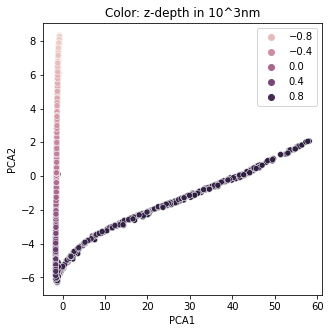

In [43]:
plt.rcParams['figure.figsize'] = [5, 5]
deterministic_model = load_deterministic_model(load_regression_model())
feature_extraction_layer = deterministic_model.feature_extraction

pred_z = feature_extraction_layer(train_dataset.data['train'][0][0]).numpy().squeeze()
zs = train_dataset.data['train'][1]
print(pred_z.shape)
from sklearn.decomposition import PCA

pcs = PCA(n_components=2).fit_transform(pred_z)
print(pcs.shape)

sns.scatterplot(pcs[:, 0], pcs[:, 1], hue=zs)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Color: z-depth in 10^3nm')
plt.show()

In [35]:
print(model.fc3)
from IPython.display import Image 

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')


NameError: name 'model' is not defined

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]


run_test(0, model)

In [ ]:
test_x, test_y = train_dataset.data['train']

n_repeats = 100

pred_y = np.array([model(test_x).numpy() for _ in range(n_repeats)]).squeeze()
try:
    mean_y = pred_y.mean(axis=0).squeeze()
    _conf95 = 1.96 * np.std(pred_y, axis=0).squeeze()
    print('Error bars', _conf95.min(), _conf95.max())
except AttributeError as e:
    print(e)
    pred_y = pred_y
    mean_y = pred_y.squeeze()
    _conf95 = np.zeros((mean_y.shape))

print('True range', test_y.min(), test_y.max())
print('Pred range', mean_y.min(), mean_y.max())

idx = np.argsort(_conf95)
test_imgs = test_x[0].squeeze()[idx]
plt.rcParams['figure.figsize'] = [200, 200]
plt.imshow(grid_psfs(test_imgs))
plt.show()


In [ ]:
%load_ext autoreload
%autoreload 2
from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import StormDataset, ExperimentalDataSet

dataset ='20220607_nanoruler_miguel'

cfg = dataset_configs[dataset]['storm_slide_1500']
ds = StormDataset(cfg, normalize_psf=True, lazy=True)
ds.prepare_data()


In [ ]:
from final_project.smlm_3d.data.visualise import scatter_3d, scatter_yz
from skspatial.objects import Plane
plt.rcParams['figure.figsize'] = [5, 5]

n_repeats = 10
coords = []
for _ in range(n_repeats):
    coords.append(ds.predict_dataset(model))

coords = np.array(coords).mean(axis=0)
scatter_3d(ds.predict_dataset(model))
scatter_yz(ds.predict_dataset(model))
p = Plane.best_fit(coords)
residuals = np.array([p.distance_point(coords[i]) for i in range(coords.shape[0])])
print(f'Mean error', residuals.mean())

In [ ]:
repeats = 5
i = 0
imgs = np.repeat(train_dataset.data['test'][0][0][i:i+10], repeats, axis=0)
coords = np.repeat(train_dataset.data['test'][0][1][i:i+10], repeats, axis=0)
bead_data = [imgs, coords]
preds = model.predict(bead_data).squeeze()
print(preds)

In [ ]:
# save_model(model)
# load_model(model)

In [ ]:
%load_ext autoreload
%autoreload 2
from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import StormDataset, ExperimentalDataSet

dataset ='easystorm'
dataset_configs[dataset]['experimental']['csv'] = '1mm_bead_surface_center_1_MMStack_Pos0_substack_filtered.csv'
cfg = dataset_configs[dataset]['experimental']
ds = ExperimentalDataSet(cfg, normalize_psf=True)

In [ ]:
repeats = 500
import seaborn as sns
plt.rcParams['figure.figsize'] = [5, 5]
for i in [0, 10, 20, 30, 40, 50]:
    bead_data = [np.repeat(ds.data[0][i:i+1], repeats, axis=0), np.repeat(ds.data[1][i:i+1], repeats, axis=0)]
    preds = model.predict(bead_data).squeeze()
    preds = np.array(preds)
    sns.histplot(preds.squeeze())
    plt.ylabel('Count')
    plt.xlabel('Pred z (nm)')
    plt.show()



In [ ]:
from final_project.smlm_3d.data.visualise import plot_w_dist, scatter_3d

preds = np.array([ds.predict_dataset(model) for _ in range(100)]).squeeze()
print(preds.shape)
preds_std = np.std(preds[:, :, 2], axis=0)
preds = np.mean(preds, axis=0)
print(preds.shape)
print(preds_std.shape)

plt.rcParams['figure.figsize'] = [10, 10]
scatter_3d(preds)
sns.histplot(preds_std)
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2


from final_project.smlm_3d.data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs, plot_w_dist
from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import ExperimentalDataSet
from final_project.smlm_3d.experiments.model_sphere import fit_sphere

import seaborn as sns
def eval_sphere_fit(coords, z_diff, title):
    radius = 5e5 + 50
    cols = ['x', 'y', 'z']
    orig_df = pd.DataFrame(coords, columns=cols)
    centre, res = fit_sphere(orig_df, radius, top_or_bottom='bottom')
    
    plt.figure()
    ax = plt.gca()
    sns.scatterplot(coords[:, 0], coords[:, 2], hue=z_diff)
    circle = plt.Circle((centre[0], centre[2]), radius=radius, fill=False)
    ax.add_artist(circle)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(title)
    plt.show()
    plot_w_dist(centre, coords, radius, z_diff)
    
    print(coords.shape)
    print(preds_std.squeeze().shape)
    plt.title('Color: STDev of prediction')
    plot_w_dist(centre, coords, radius, preds_std.squeeze())

    
    worst_imgs = np.argsort(abs(res))[::-1]
#     for i in worst_imgs[0:10]:
#         print(i, z_diff[i], res[i])
#         plt.imshow(exp_dataset.data[0][i])
#         plt.show()
    
    res = abs(res)
#     res = res[res < np.percentile(res, 75)]
    plt.boxplot(res)
    plt.show()
    print(np.mean(res))
    print(np.std(res))
    return res
    
    
plt.rcParams['figure.figsize'] = [10, 10]
scatter_yz(preds)
original_coords = ds.xyz_coords.copy()
# eval_sphere_fit(original_coords)

z_diff = (preds[:, 2] - original_coords[:, 2])
res = eval_sphere_fit(preds, z_diff, title='Predicted')
print(z_diff[0:5])


idx = np.argsort(z_diff)
pred_frames = ds.data[0][idx].squeeze()
plt.rcParams['figure.figsize'] = [10, 10]
plt.title('Ordered by increasing pred z')
plt.imshow(grid_psfs(pred_frames))
plt.show()

idx = np.argsort(preds_std)
pred_frames = ds.data[0][idx].squeeze()
plt.rcParams['figure.figsize'] = [10, 10]
plt.title('Ordered by increasing STDev')
plt.imshow(grid_psfs(pred_frames))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]

def multi_predict(x, repeats=5):
    results = np.zeros((x[0].shape[0], repeats))
    for i in range(repeats):
        results[:, i] = model.predict(test_x).squeeze()
    return results
    

test_x, test_y = train_dataset.data['test']

results = multi_predict(test_x, 5)

pred_y = np.mean(results, axis=1)
error = np.std(results, axis=1)


error = abs(test_y-pred_y)
print(f'Mean error {np.mean(error)}')
print(f'std error {np.std(error)}')

# plt.scatter(test_y, pred_y)
# plt.errorbar(test_y, pred_y, yerr=error, fmt="o")

import seaborn as sns
fig, ax = plt.subplots()
g = sns.scatterplot(test_y, pred_y, hue=error)
plt.title('Colour: STDev of prediction')
plt.xlabel('True z (nm)')
plt.ylabel('Pred z (nm)')
plt.show()

In [ ]:
# from keras import Model, Input, layers
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# import tensorflow_probability as tfp
# tfd = tfp.distributions

# negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# model = load_model(load_regression_model())
# model.trainable = False
# model.prob_space = True

# train_size = len(train_dataset.data['train'][0][0])


# def prior(kernel_size, bias_size, dtype=None):
#     n = kernel_size + bias_size
#     prior_model = keras.Sequential(
#         [
#             tfp.layers.DistributionLambda(
#                 lambda t: tfp.distributions.MultivariateNormalDiag(
#                     loc=tf.zeros(n), scale_diag=tf.ones(n)
#                 )
#             )
#         ]
#     )
#     return prior_model


# # Define variational posterior weight distribution as multivariate Gaussian.
# # Note that the learnable parameters for this distribution are the means,
# # variances, and covariances.
# def posterior(kernel_size, bias_size, dtype=None):
#     n = kernel_size + bias_size
#     posterior_model = keras.Sequential(
#         [
#             tfp.layers.VariableLayer(
#                 tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
#             ),
#             tfp.layers.MultivariateNormalTriL(n),
#         ]
#     )
#     return posterior_model

# img_input = Input(shape=(32, 32, 1), name='img')
# coords_input = Input(shape=(2,), name='coords')

# features = model((img_input, coords_input))

# features = tf.concat([features, coords_input], axis=-1)

# features = layers.BatchNormalization()(features)
# hidden_units = [4]


# for units in hidden_units:
# #     features = keras.layers.Dense(units=units)(features)
#     features = tfp.layers.DenseVariational(
#         units=units,
#         make_prior_fn=prior,
#         make_posterior_fn=posterior,
#         kl_weight=1 / train_size,
#         activation='sigmoid',
#     )(features)
    
# encoded_shape = hidden_units[-1]

# distribution_params = layers.Dense(units=tfp.layers.IndependentNormal.params_size(encoded_shape))(features)
# outputs = tfp.layers.IndependentNormal(1)(distribution_params)

# bayesian_model = Model(inputs=[img_input, coords_input], outputs=[outputs])


# callbacks = [
#     ReduceLROnPlateau(
#     monitor='loss', factor=0.1, patience=20, verbose=True,
#     mode='min', min_delta=1, cooldown=0, min_lr=1e-10,),
#     EarlyStopping(monitor='val_mean_absolute_error', patience=200, verbose=True, min_delta=1, restore_best_weights=True),
# ]

# metrics = [
#     keras.metrics.MeanAbsoluteError()
# ]
# bayesian_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-2), loss=negloglik, metrics=metrics)

# print(bayesian_model.summary())
# history = bayesian_model.fit(*train_dataset.data['train'], epochs=500, batch_size=64, callbacks=callbacks, validation_data=(*train_dataset.data['val'],), verbose=True)

In [ ]:
# import tensorflow as tf
# import tensorflow_probability as tfp
# tfd = tfp.distributions

# # Build model.
# model = tf.keras.Sequential([
#   tf.keras.layers.Dense(1),
#   tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=np.exp(t))),
# ])

# # Do inference.
# model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)


# x = tf.random.uniform((500, 1))
# x = x - np.mean(x)
# noise = tf.random.uniform((500, 1)) / 2
# y = x
# x = x + (noise * x)

# history = model.fit(x, y, epochs=5, verbose=False)
# plt.plot(history.history['loss'])
# plt.show()

# # Make predictions.
# yhat = model(x)
# print(yhat.__dict__)

In [ ]:
# plt.rcParams['figure.figsize'] = [20, 5]

# fig, ax1 = plt.subplots()
# ax1.plot(history.history['mean_absolute_error'], label='mse')
# ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
# ax1.set_yscale('log')
# ax1.legend(loc=1)
# ax2 = ax1.twinx()
# ax2.plot(history.history['lr'], label='lr')
# ax2.legend(loc=0)
# plt.xlim(0, len(history.history['mean_absolute_error']))
# plt.ylabel('MAE (nm)')
# plt.xlabel('epochs')
# plt.show()

In [ ]:
test_x, test_y = train_dataset.data['test']
pred_y_dist = model.predict(test_x)

avgs = pred_y_dist.mean().numpy().squeeze()
var = pred_y_dist.variance().numpy().squeeze()

plt.scatter(test_y, avgs)
plt.errorbar(test_y, avgs, yerr=var, fmt=".")
plt.show()


In [ ]:
test_x, test_y = train_dataset.data['test']
pred_y = model(test_x).numpy().squeeze()
print(pred_y.shape)
error = abs(test_y-pred_y)
print(f'Mean error {np.mean(error)}')
print(f'std error {np.std(error)}')

# Mean error 32.48721585546437
# std error 34.79553158370339


idx = np.argsort(pred_y)
test_imgs = test_x[0].squeeze()[idx]
plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(grid_psfs(test_imgs))
plt.show()

plt.rcParams['figure.figsize'] = [3, 5]
plt.scatter(test_y, pred_y)
plt.show()
error = abs(pred_y-test_y)
plt.boxplot(error)
plt.show()